# Quick and dirty visualization of the COVID-19 pandemic & a very unscientific logistic regression

In [1]:
import urllib
import numpy as np
from scipy.optimize import differential_evolution
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Get and process WHO/ECDC data

Note that we remove China from all considerations, also its contribution to the worldwide data. We do so, because we think that there are multiple reasons it improves our analysis of the data.

Source: https://ourworldindata.org/coronavirus-source-data

Further link recommendations:
* https://www.youtube.com/watch?v=MZ957qhzcjI
* https://www.youtube.com/watch?v=Kas0tIxDvrg
* https://www.youtube.com/watch?v=Fx11Y4xjDwA (German)
* http://www.cmih.maths.cam.ac.uk/call-for-collaboration-for-development-of-ai-support-for-covid-19-diagnosis/
* https://www.youtube.com/watch?v=gxAaO2rsdIs&t=0s

In [2]:
# url = "http://cowid.netlify.com/data/full_data.csv"
# url = "https://covid.ourworldindata.org/data/who/full_data.csv"
url = "https://covid.ourworldindata.org/data/ecdc/full_data.csv"
urllib.request.urlretrieve(url, "full_data.csv")
raw_df = pd.read_csv("full_data.csv").sort_values("date", ascending=True)

In [3]:
def get_locational_data(location, drop_location=True, replace_nan=True, reindex=True):
    df_local = raw_df[raw_df['location'] == location].set_index("date")
    if drop_location:
        df_local = df_local.drop(['location'], axis=1)
    if replace_nan:
        df_local = df_local.fillna(0)

    df_local.index = pd.to_datetime(df_local.index, format='%Y-%m-%d')
    if reindex and location != "World" and location != "China":
        earliest_date = get_locational_data("World").index.min()
        newest_date = df_local.index.max()
        idx = pd.date_range(earliest_date, newest_date)
        df_local = df_local.reindex(idx, fill_value=0)

    if location == "World":
        return df_local - get_locational_data("China")
    return df_local

earliest_date = get_locational_data("World").index.min()
newest_date = get_locational_data("World").index.max()
print(f"Our first data comes from the {earliest_date.date()} and our newest from the {newest_date.date()}.")

Our first data comes from the 2019-12-31 and our newest from the 2020-04-11.


In [4]:
def get_statistically_informative_locations(min_number_of_total_cases=11000):
    locations = list(raw_df.location.unique())

    informative_locations = []
    for location in locations:
        df_local = get_locational_data(location)

        if location == "China":
            continue
        if df_local.total_cases.max() < min_number_of_total_cases:
            continue

        informative_locations += [location]

    return informative_locations

informative_locations = sorted(get_statistically_informative_locations())
print(f"We will focus on the {len(informative_locations)} locations:", ", ".join(informative_locations))

We will focus on the 17 locations: Austria, Belgium, Brazil, Canada, France, Germany, Iran, Italy, Netherlands, Portugal, Russia, Spain, Switzerland, Turkey, United Kingdom, United States, World


## Plot ``informative_locations`` to get an overview of the development.

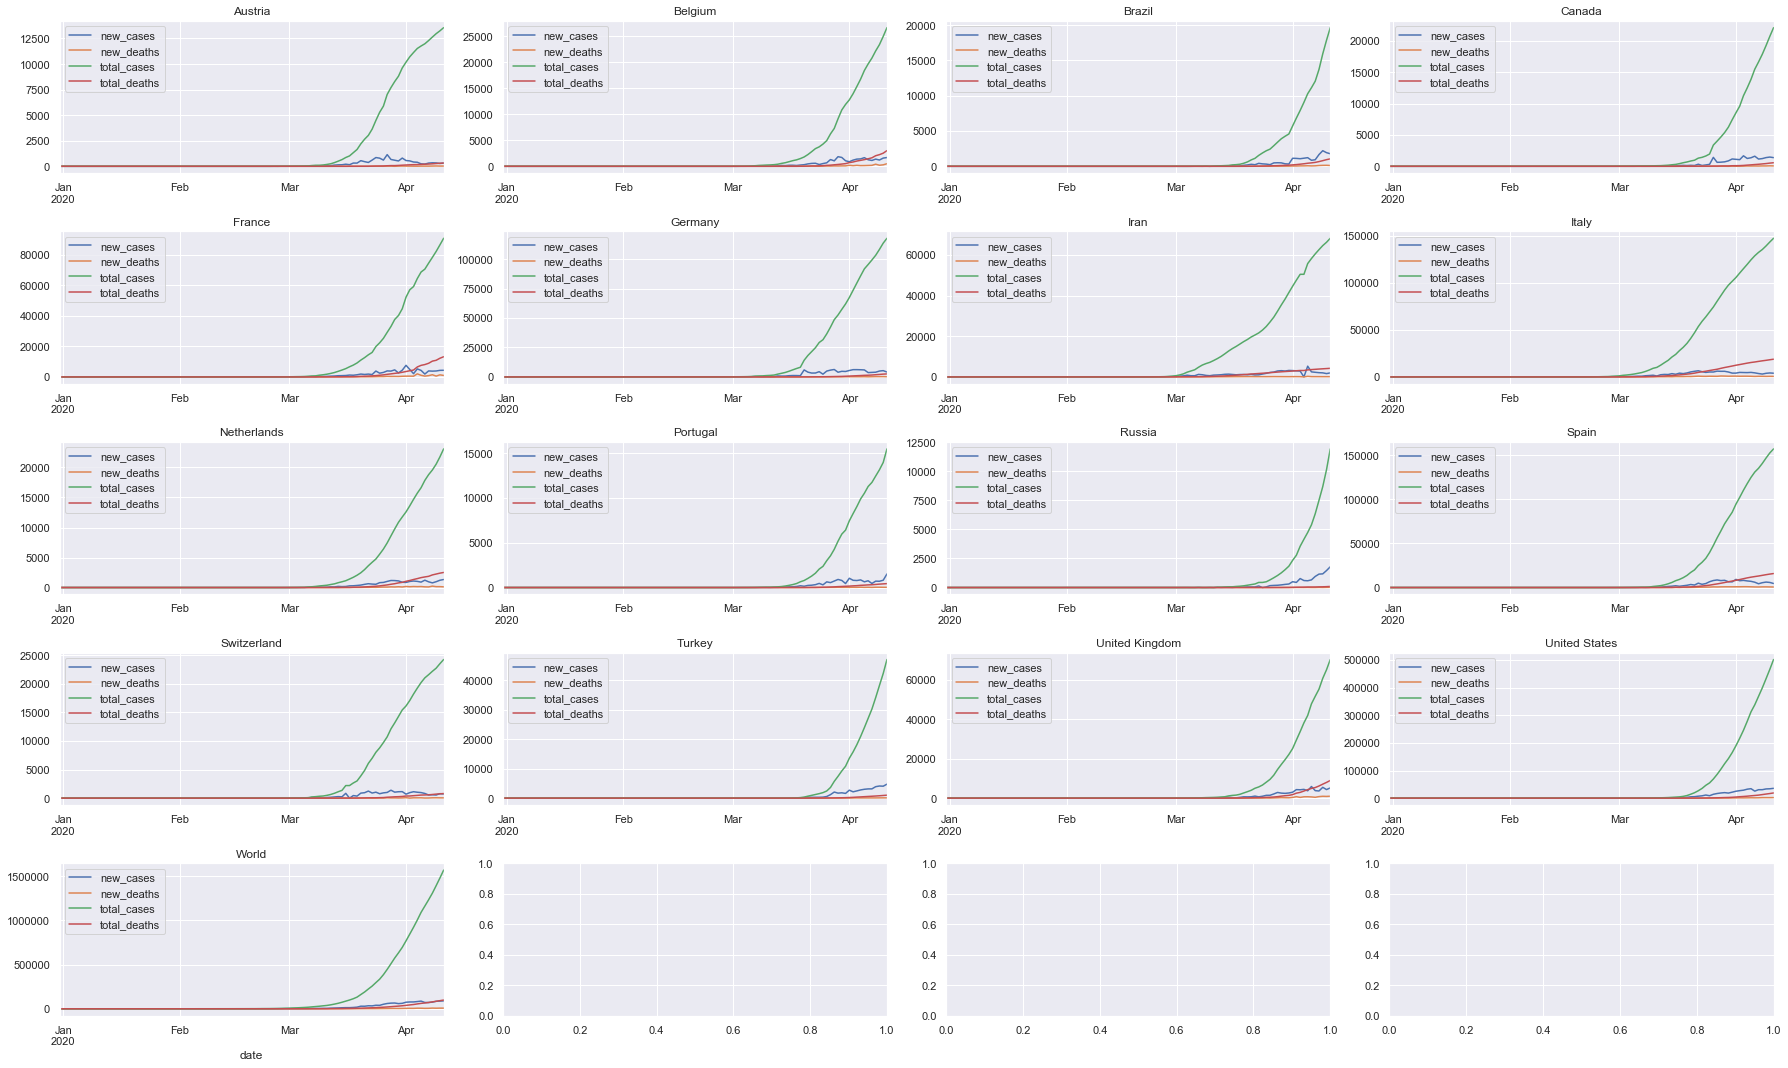

In [5]:
def plot_informative_locations(log_plot=False):
    m = int(np.ceil(np.sqrt(len(informative_locations))))
    n = int(np.ceil(len(informative_locations) / m))
    fig, axes = plt.subplots(m,n, figsize = (25, 15))

    for i, location in enumerate(informative_locations):
        df_local = get_locational_data(location)
        ax = axes[i//n, i%n]
        ax.set_title(location)
        df_local.plot(ax=ax, logy=log_plot)

    fig.tight_layout()
    plt.show()

plot_informative_locations(log_plot=False)

### Log-plot ``informative_locations``

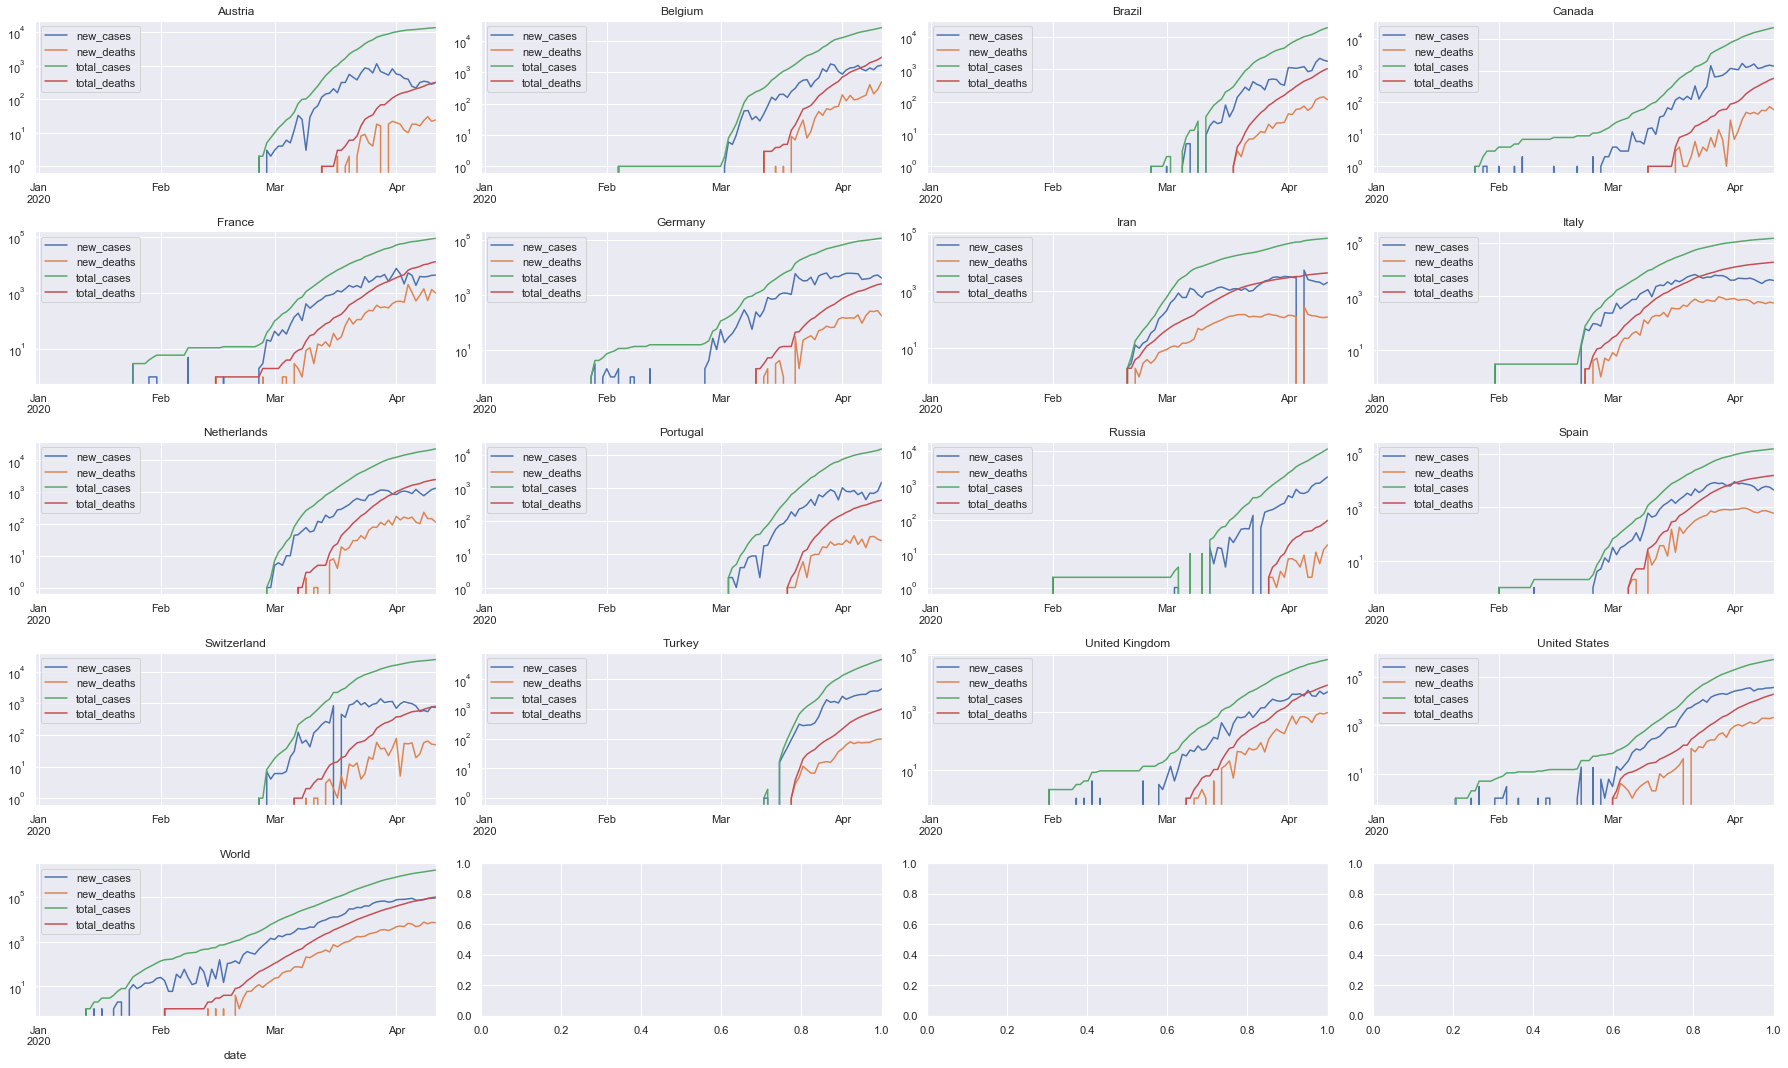

In [6]:
plot_informative_locations(log_plot=True)

### Percentage of ``total_deaths`` over ``total_cases``

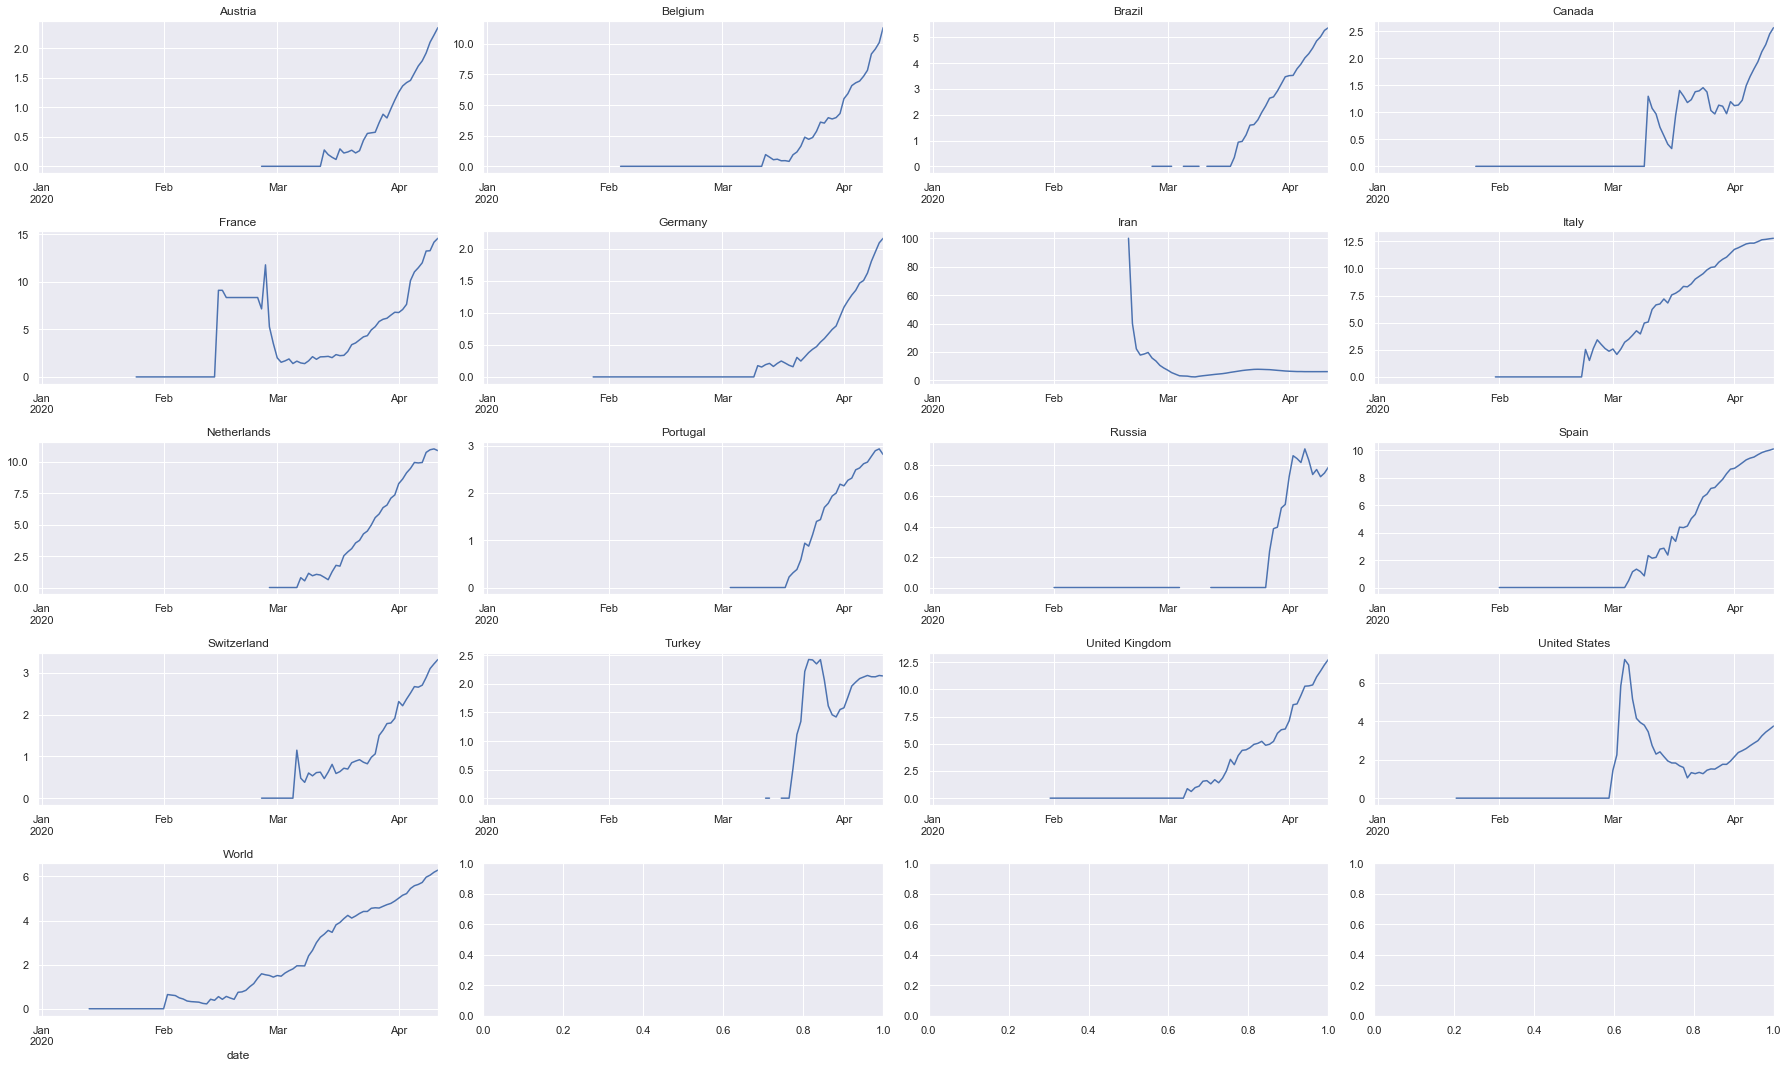

In [7]:
m = int(np.ceil(np.sqrt(len(informative_locations))))
n = int(np.ceil(len(informative_locations) / m))
fig, axes = plt.subplots(m,n, figsize = (25, 15))

for i, location in enumerate(informative_locations):
    df_local = get_locational_data(location)
    df_local = 100 * df_local.total_deaths / df_local.total_cases
    ax = axes[i//n, i%n]
    ax.set_title(location)
    df_local.plot(ax=ax)

fig.tight_layout()
plt.show()

# Code for regressions based on ``logistic_curve`` and Poisson noise

In [8]:
def logistic_curve(curves_maximum_value, growth_rate, midpoint, x):
    """
    Logistic curve, see https://en.wikipedia.org/wiki/Logistic_function
    """
    return curves_maximum_value / (1 + np.exp(-growth_rate*(x-midpoint)))

def get_logistic_curve_loss(curves_maximum_value, growth_rate, midpoint, xs, ys):
    ys_predict = logistic_curve(curves_maximum_value, growth_rate, midpoint, xs)
    loss = np.sum((ys - ys_predict)**2)
    return loss

In [9]:
def fit_logistic_function(xs, ys, max_people):
    bounds = [(np.max(ys), max_people), (0, 1), (np.min(xs), np.max(xs)+200)]

    loss = lambda parameters: get_logistic_curve_loss(parameters[0], parameters[1], parameters[2], xs, ys)
    result = differential_evolution(loss, bounds, polish=True)

    best_curves_maximum_value, best_growth_rate, best_midpoint = result['x']
    return (best_curves_maximum_value, best_growth_rate, best_midpoint)

In [10]:
def plot_100(location, location_population, x_ticks_subsampling, days_into_future=7):
    df_local = get_locational_data(location)[50:]
    calendar = pd.date_range(df_local.index[0], '2020-12-31').date
    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values

    for _ in range(200):
        ys_delta = np.random.poisson(ys)
        best_curves_maximum_value, best_growth_rate, best_midpoint = fit_logistic_function(xs, ys_delta, max_people=location_population)
        xs_predict = np.arange(len(df_local) + days_into_future)
        ys_predict = logistic_curve(best_curves_maximum_value, best_growth_rate, best_midpoint, xs_predict)
        plt.plot(xs_predict, ys_predict, c='r', linestyle='dotted')

    plt.plot(xs, ys, c='b')
    xs_ticks = xs_predict[::x_ticks_subsampling]
    plt.xticks(xs_ticks, calendar[xs_ticks], rotation="vertical")
    fig = plt.gcf()
    fig.set_size_inches(20,2)
    plt.show()

In [11]:
from IPython.display import clear_output

In [12]:
from multiprocessing import Pool

def run_simulation(simulation_args):
    xs, ys_delta, location_population = simulation_args
    return fit_logistic_function(xs, ys_delta, max_people=location_population)

In [13]:
def histograms(location, location_population, x_ticks_subsampling, n_samples=10000):
    df_local = get_locational_data(location)[50:]
    calendar = pd.date_range(df_local.index[0], '2020-12-31').date
    xs = np.arange(len(df_local))
    ys = df_local['total_cases'].values

    simulation_args = [(xs, np.random.poisson(ys), location_population) for _ in range(n_samples)]
    pool = Pool(16)
    best_values = pool.map(run_simulation, simulation_args)

    maximum_values = np.array(best_values)[:,0]
    plt.subplot(131)
    plt.title(f"total confirmed infected\n mean:"+
              f"{int(round(np.mean(maximum_values)))}\n median:"+
              f"{int(round(np.median(maximum_values)))}\n std:"+
              f"{int(round(np.std(maximum_values)))}")
    plt.hist(maximum_values)
    plt.ylim(bottom=0)

    maximum_per_day_s = np.array(best_values)[:,0] * np.array(best_values)[:,1]
    plt.subplot(132)
    plt.title(f"maximum confirmed infected per day \n mean:"+
              f"{int(round(np.mean(maximum_per_day_s)))}\n median:"+
              f"{int(round(np.median(maximum_per_day_s)))}\n std:"+
              f"{int(round(np.std(maximum_per_day_s)))}")
    plt.hist(maximum_per_day_s)

    peaks = np.array(best_values)[:,2]
    plt.subplot(133)
    plt.title(f"Peak in how many days \n mean:"+
              f"{calendar[int(round(np.mean(peaks)))]}\n"+
              f"median: {calendar[int(round(np.median(peaks)))]}\n std:"+
              f"{round(np.std(peaks), 1)} days")
    bins = np.arange(np.floor(np.min(peaks)), np.ceil(np.max(peaks)), x_ticks_subsampling)
    hist, bins = np.histogram(peaks, bins=bins)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    ax = plt.gca()
    ax.bar(center, hist, align='center', width=width)
    ax.set_xticks(bins)
    ax.set_xticklabels(calendar[bins.astype(int)], rotation='vertical')


    fig = plt.gcf()
    fig.set_size_inches(20,4) 
    plt.show()

# Regressions: 200 predictions & histogram of parameters over 10000 predictions
## Note that, until we are in the saturation phase, all long term predictions (like the final number of infected people) are essentially worthless (see ill-posedness/instability). There is also good reason to belief that a logistic curve is a very over-simplistic model.

## For the world (without China)

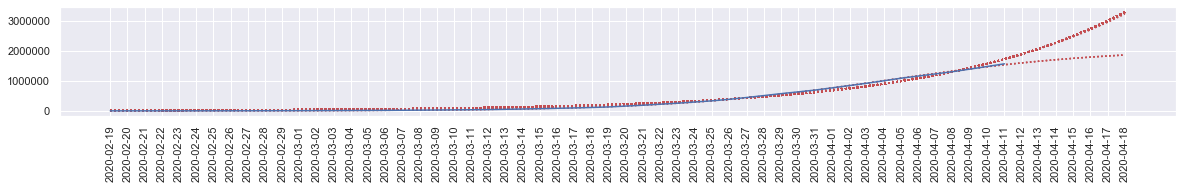

In [14]:
location = "World"
location_population = 6.3e9
plot_100(location, location_population, 1)

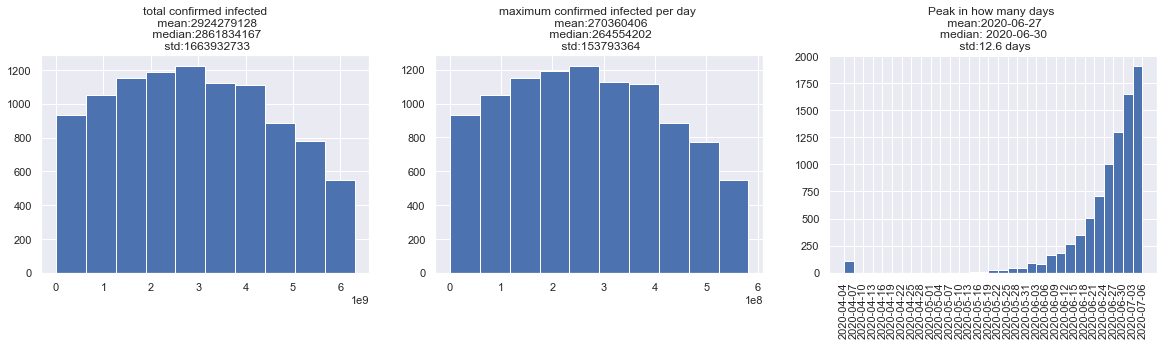

In [15]:
histograms(location, location_population, 4)

## For Germany

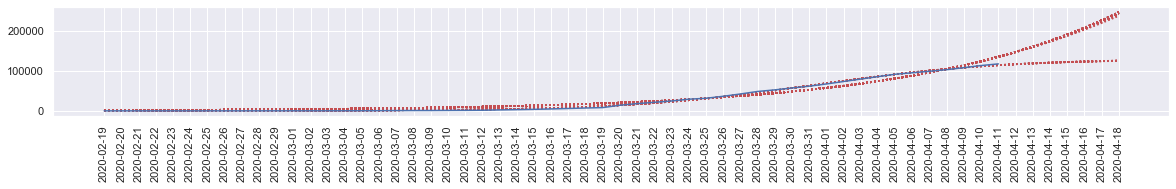

In [16]:
location = "Germany"
location_population = 82e6
plot_100(location, location_population, 1)

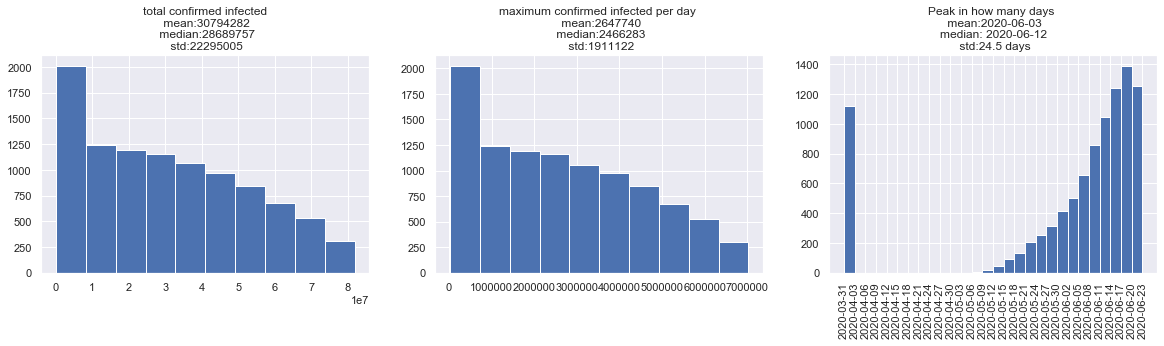

In [17]:
histograms(location, location_population, 4)

## For the USA

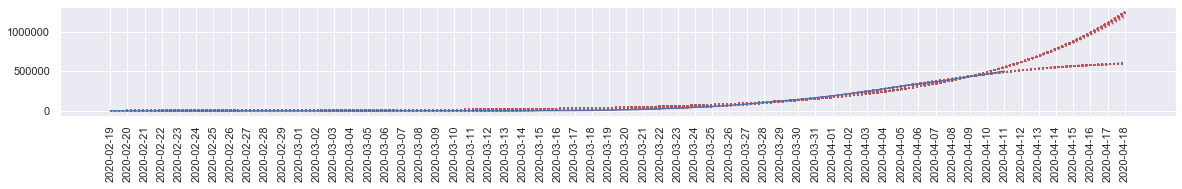

In [18]:
location = "United States"
location_population = 327e6
plot_100(location, location_population, 1)

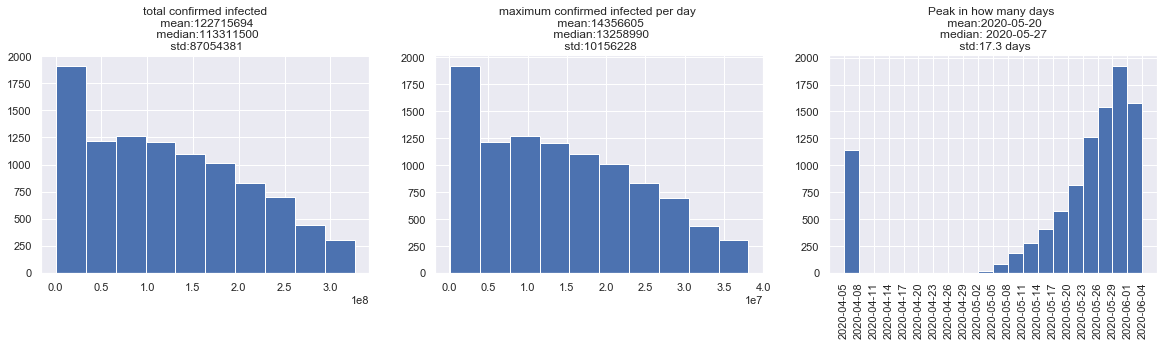

In [19]:
histograms(location, location_population, 3)

## For Italy

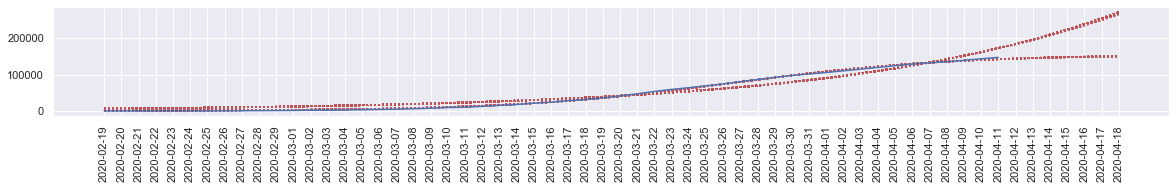

In [20]:
location = "Italy"
location_population = 60e6
plot_100(location, location_population, 1)

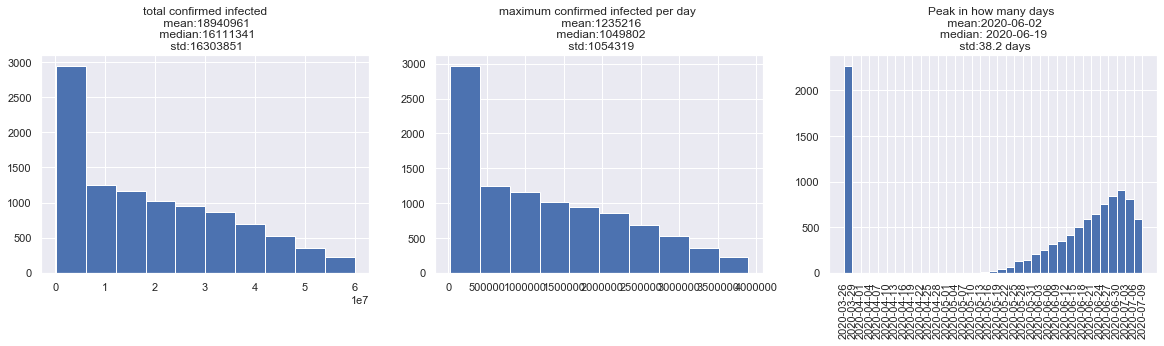

In [21]:
histograms(location, location_population, 4)